# German Credit Risk Analysis

## 1. Introduction and Objectives
This analysis aims to identify the profiles of users likely to be classified as "good" or "bad" payers utilizing the German Credit Risk dataset. The study proceeds through the following steps:

1.  **Data Cleaning & Exploration**: Examines the dataset structure and addresses missing values to ensure data quality.

2.  **EDA (Exploratory Data Analysis)**: Visualizes variable distributions and explores relationships with the target variable (`Risk`) to uncover underlying patterns.

3.  **Statistical Analysis**: Conducts hypothesis testing (Chi-Square, T-Tests) to statistically validate the observed relationships.

4.  **Modeling**: Constructs Logistic Regression and Random Forest models to estimate credit risk probabilities with predictive accuracy.

5.  **Profile Identification**: Defines the characteristics of the most probable 'Good' and 'Bad' payers and quantifies the distinction in their predicted probabilities.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

# Configuration for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Loading and Cleaning

In [5]:
# Load the dataset
file_path = '../../datasets/credit_score_dataset/german_credit_risk_v1.0.0_training_23012026.csv'
try:
    df = pd.read_csv(file_path, index_col=0)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path.")

# Display first rows
display(df.head())

# Check info
print(df.info())

Dataset loaded successfully.


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


### Handling Missing Values
The columns `Saving accounts` and `Checking account` contain missing values, as indicated by the `df.info()` summary. In this context, these missing values are interpreted as "No Account", representing valuable information rather than missing data. The analysis fills these entries with a new category label 'unknown'.

In [6]:
# Fills NA values with 'unknown'
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# Verify no missing values remain
print(df.isnull().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64


In [7]:
#resumen de las variables numericas 
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [8]:
# resumen de las variables categoricas
df.describe(include='object')

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,1000,1000,1000,1000
unique,2,3,5,4,8,2
top,male,own,little,unknown,car,good
freq,690,713,603,394,337,700


## 3. Exploratory Data Analysis (EDA)

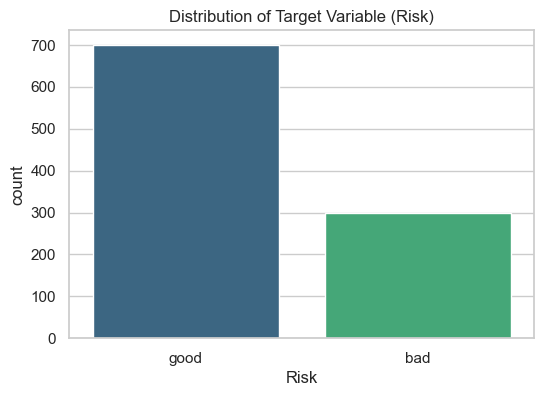

In [9]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk', data=df, hue='Risk', legend=False, palette='viridis')
plt.title('Distribution of Target Variable (Risk)')
plt.show()

The image above shows an imbalance in the target variable 'Risk', where 70% (700) of the observations belong to the 'good' category and 30% (300) to 'bad'. 

This imbalance presents several challenges for model training:

1. **Majority class bias:** The algorithm will tend to predict the 'good' label more frequently, hindering the correct detection of risk profiles ('bad').

2. **Misleading metrics:** Using 'accuracy' can be counterproductive, as a model that consistently predicts 'good' would achieve 70% accuracy without truly learning to identify critical cases.

3. **Poor generalization:** The model may fail to capture sufficient patterns from the minority class, resulting in a high rate of false negatives.

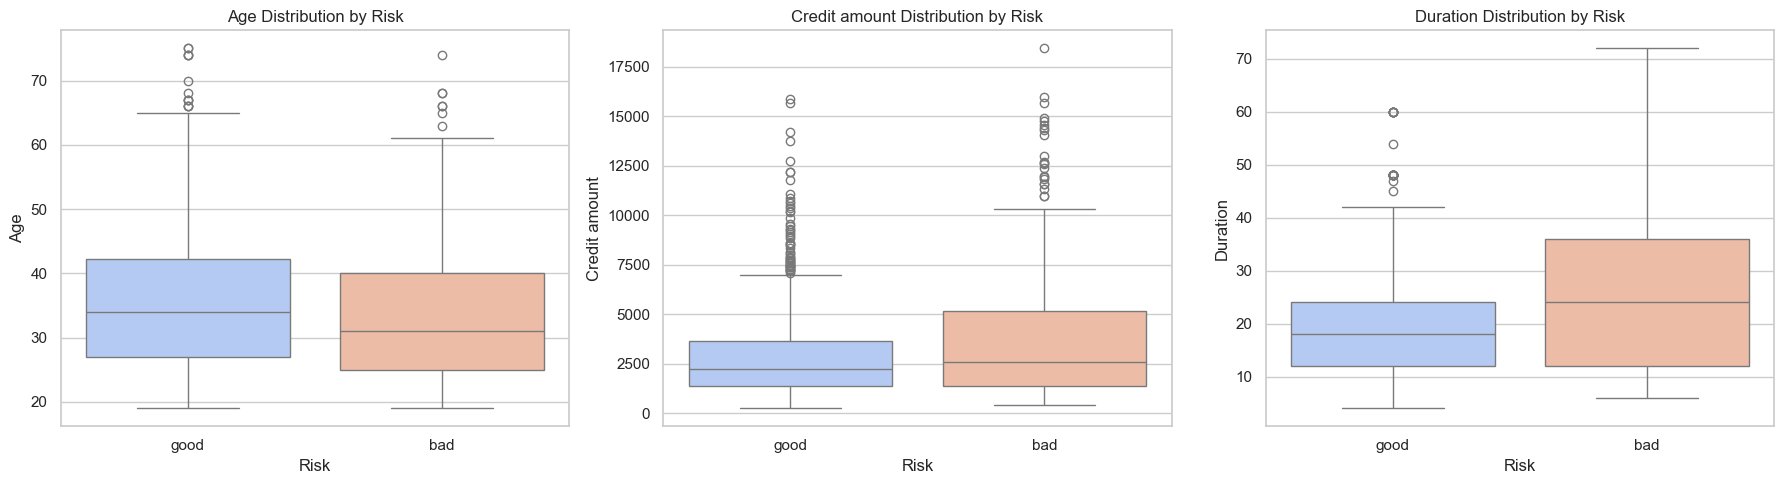

In [10]:
# Numerical Distributions by Risk
num_cols = ['Age', 'Credit amount', 'Duration']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_cols):
    sns.boxplot(x='Risk', y=col, data=df, ax=axes[i], hue='Risk', legend=False, palette='coolwarm')
    axes[i].set_title(f'{col} Distribution by Risk')

plt.tight_layout()
plt.show()

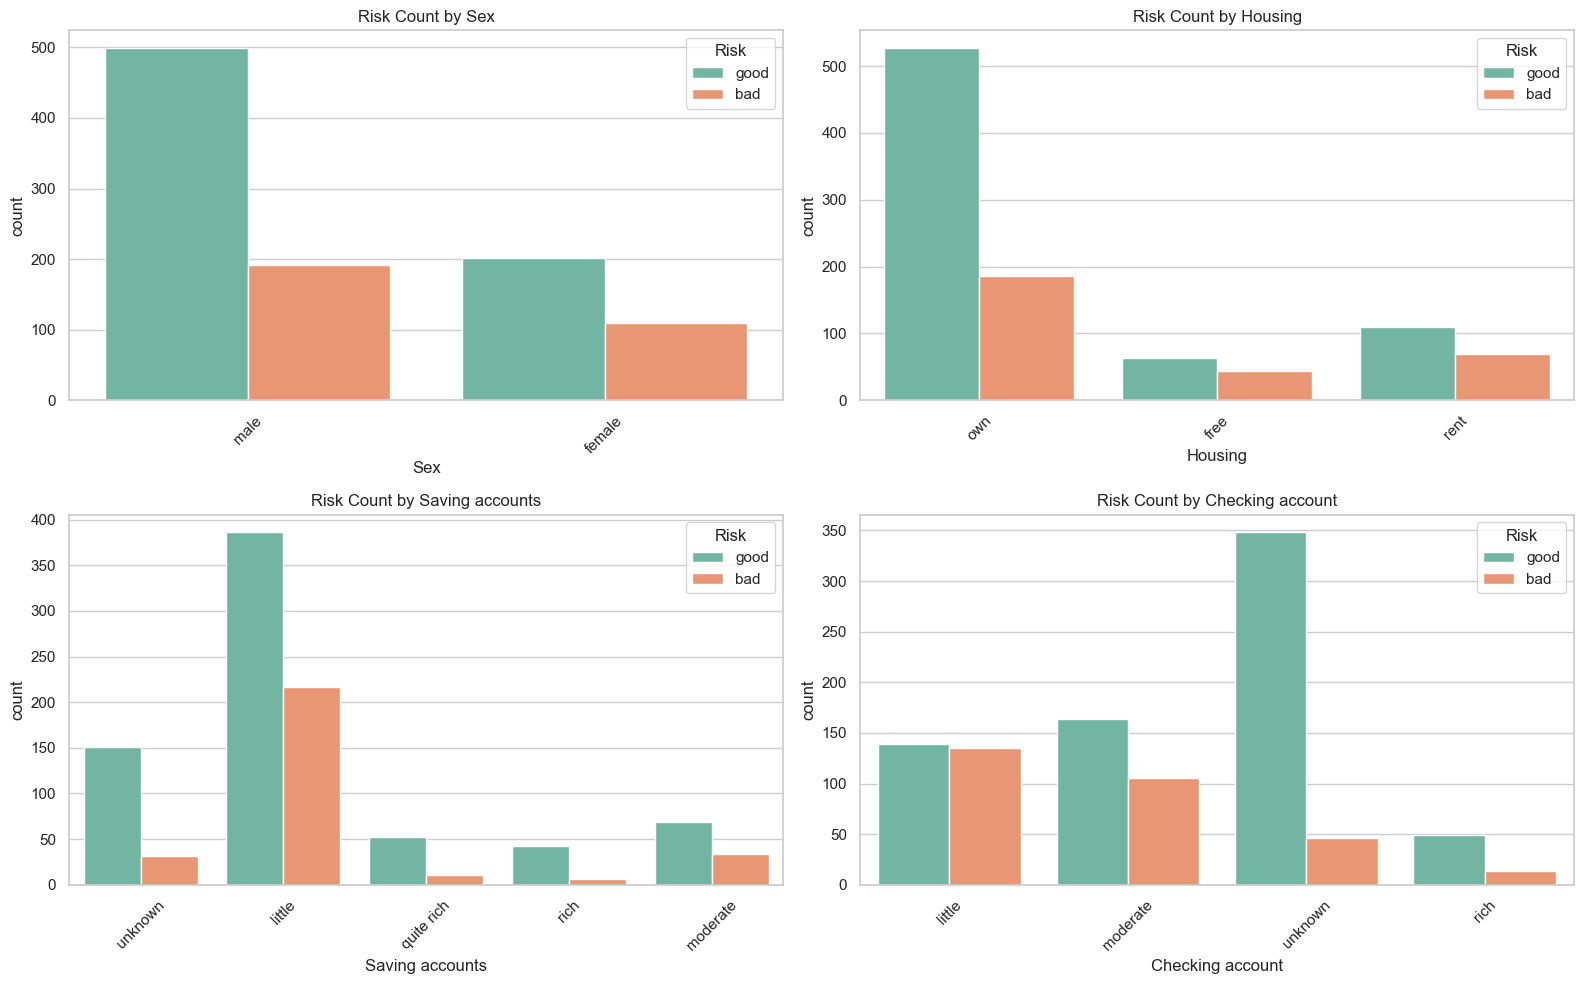

In [11]:
# Categorical Analysis
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for i, col in enumerate(cat_cols):
    row, col_idx = divmod(i, 2)
    sns.countplot(x=col, hue='Risk', data=df, ax=axes[row, col_idx], palette='Set2')
    axes[row, col_idx].set_title(f'Risk Count by {col}')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

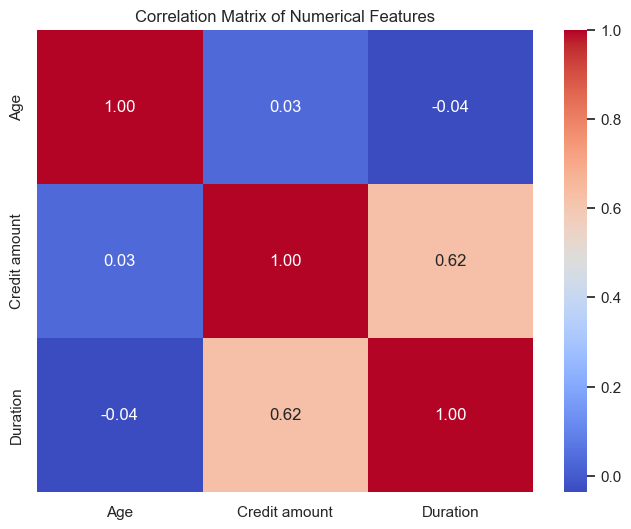

In [12]:
# Correlation Matrix (Numerical)
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 4. Statistical Analysis
We will perform tests to quantify the relationships visualized above.

- **Chi-Square Test**: For categorical variables vs Risk.

- **T-Test**: For numerical variables vs Risk.

**Hypothesis:**

- Null ($H_0$): No significant difference/association between the feature and Risk.

- Alt ($H_1$): There is a significant difference/association.

In [13]:
results_stats = []

# Chi-Square for Categorical
input_cat_cols = df.select_dtypes(include=['object']).columns.drop('Risk')
print("--- Chi-Square Method Results ---")
for col in input_cat_cols:
    contingency_table = pd.crosstab(df[col], df['Risk'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    sig = "Significant" if p < 0.05 else "Not Significant"
    results_stats.append({'Feature': col, 'Test': 'Chi-Square', 'P-Value': p, 'Result': sig})
    print(f"{col}: p-value = {p:.5f} ({sig})")

# T-Test for Numerical
print("\n--- T-Test Method Results ---")
good_risk = df[df['Risk'] == 'good']
bad_risk = df[df['Risk'] == 'bad']

for col in num_cols:
    stat, p = ttest_ind(good_risk[col], bad_risk[col], equal_var=False)
    sig = "Significant" if p < 0.05 else "Not Significant"
    results_stats.append({'Feature': col, 'Test': 'T-Test', 'P-Value': p, 'Result': sig})
    print(f"{col}: p-value = {p:.5f} ({sig})")

--- Chi-Square Method Results ---
Sex: p-value = 0.02074 (Significant)
Housing: p-value = 0.00011 (Significant)
Saving accounts: p-value = 0.00000 (Significant)
Checking account: p-value = 0.00000 (Significant)
Purpose: p-value = 0.05793 (Not Significant)

--- T-Test Method Results ---
Age: p-value = 0.00379 (Significant)
Credit amount: p-value = 0.00002 (Significant)
Duration: p-value = 0.00000 (Significant)


## 5. Feature Engineering and Modeling

In [14]:
# Preprocessing
# Encode Target: Good -> 1, Bad -> 0 
# (Usually we want to predict specific class, let's map Good=1 for 'Good Payer' probability)

df['Risk_Binary'] = df['Risk'].map({'good': 1, 'bad': 0})

# Features X and Target y
X = df.drop(['Risk', 'Risk_Binary'], axis=1)
y = df['Risk_Binary']

# Feature Selection based on Stats (all seem potential, but Purpose is string)
# We will encode everything.

# Identify column types
numeric_features = ['Age', 'Credit amount', 'Duration', 'Job', 'Checking account_ord', 'Saving accounts_ord'] 
# Job is numeric in dataset but categorical in nature. Let's treat as Cat for OHE or Ordinal?
# Actually Job is 0,1,2,3 - Ordinal nature. Checking/Saving have 'little', 'moderate', etc. - Ordinal nature.

# Let's map ordinal variables manually for better representation
saving_map = {'unknown': 0, 'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
checking_map = {'unknown': 0, 'little': 1, 'moderate': 2, 'rich': 3}

df['Saving_Ordinal'] = df['Saving accounts'].map(saving_map)
df['Checking_Ordinal'] = df['Checking account'].map(checking_map)

# Refresh X with engineered features
X = df.drop(['Risk', 'Risk_Binary', 'Saving accounts', 'Checking account'], axis=1)

# Update feature lists
# Categorical to OHE: Sex, Housing, Purpose
# Numerical/Ordinal: Age, Credit amount, Duration, Job, Saving_Ordinal, Checking_Ordinal

nominal_features = ['Sex', 'Housing', 'Purpose']
numerical_features = ['Age', 'Credit amount', 'Duration', 'Job', 'Saving_Ordinal', 'Checking_Ordinal']

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (800, 9), Test shape: (200, 9)


In [15]:
from sklearn.preprocessing import OneHotEncoder

# Defines Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Trains and Evaluates
trained_models = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print(classification_report(y_test, y_pred))
    
    trained_models[name] = pipeline


--- Logistic Regression ---
Accuracy: 0.6800
ROC AUC: 0.6611
              precision    recall  f1-score   support

           0       0.44      0.25      0.32        60
           1       0.73      0.86      0.79       140

    accuracy                           0.68       200
   macro avg       0.59      0.56      0.55       200
weighted avg       0.64      0.68      0.65       200


--- Random Forest ---
Accuracy: 0.7400
ROC AUC: 0.7358
              precision    recall  f1-score   support

           0       0.59      0.43      0.50        60
           1       0.78      0.87      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.72      0.74      0.73       200



## 6. Profile Identification
This section identifies the "Good Payer" and "Bad Payer" profiles by isolating clusters of users associated with the highest predicted probabilities for each respective class.

In [16]:
# Uses Random Forest model for profiling as it often performs better
best_model = trained_models['Random Forest']

# Gets probabilities for the entire dataset
all_probs = best_model.predict_proba(X)[:, 1] # Prob of class 1 (Good)

# Creates a DataFrame with original data and probabilities
profile_df = df.copy()
profile_df['Prob_Good'] = all_probs
profile_df['Prob_Bad'] = 1 - all_probs

# Defines Top Deciles
top_good_threshold = profile_df['Prob_Good'].quantile(0.90)
top_bad_threshold = profile_df['Prob_Bad'].quantile(0.90)

top_good_payers = profile_df[profile_df['Prob_Good'] >= top_good_threshold]
top_bad_payers = profile_df[profile_df['Prob_Bad'] >= top_bad_threshold]

# Calculates Probability Difference
avg_prob_good_group = top_good_payers['Prob_Good'].mean()
avg_prob_bad_group = top_bad_payers['Prob_Good'].mean() # Prob of being good for the bad group
prob_diff = avg_prob_good_group - avg_prob_bad_group

print(f"Average Probability of Good Payer in 'Good Profile' Group: {avg_prob_good_group:.2%}")
print(f"Average Probability of Good Payer in 'Bad Profile' Group: {avg_prob_bad_group:.2%}")
print(f"Difference (Good Profile - Bad Profile): {prob_diff:.2%}")

# Extracts Profiles (Modes for Categorical, Means for Numerical)
def extract_profile(sub_df, name):
    print(f"\n--- {name} Profile Characteristics ---")
    print(sub_df[num_cols].mean().to_string())
    for col in cat_cols:
        print(f"{col} Mode: {sub_df[col].mode()[0]}")
        
extract_profile(top_good_payers, "Likely Good Payer")
extract_profile(top_bad_payers, "Likely Bad Payer")

Average Probability of Good Payer in 'Good Profile' Group: 98.17%
Average Probability of Good Payer in 'Bad Profile' Group: 13.01%
Difference (Good Profile - Bad Profile): 85.16%

--- Likely Good Payer Profile Characteristics ---
Age                39.437500
Credit amount    2432.993056
Duration           17.083333
Sex Mode: male
Housing Mode: own
Saving accounts Mode: little
Checking account Mode: unknown

--- Likely Bad Payer Profile Characteristics ---
Age                31.817308
Credit amount    4508.605769
Duration           30.817308
Sex Mode: male
Housing Mode: own
Saving accounts Mode: little
Checking account Mode: little


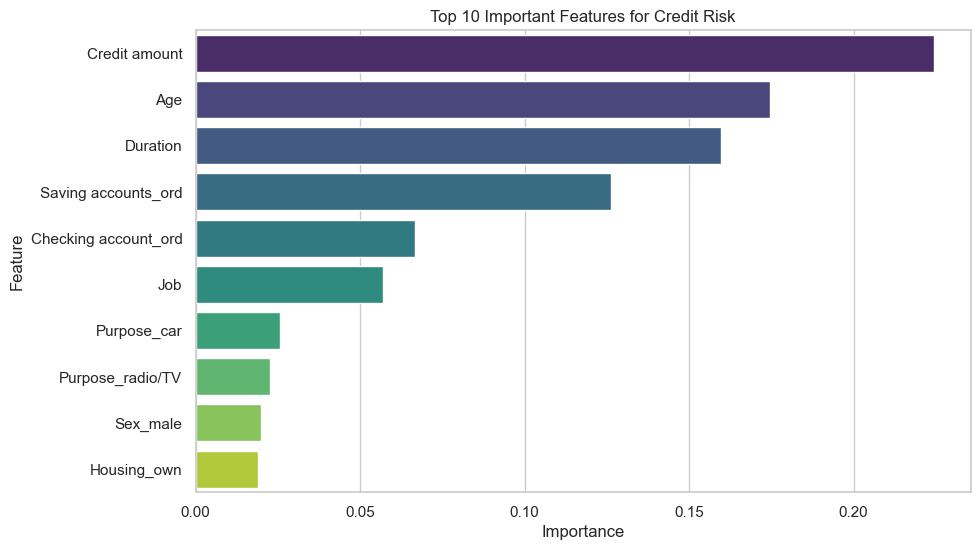

In [17]:
# Additional Feature Importance to support profile
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = numeric_features + list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(nominal_features))

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, hue='Feature', legend=False, palette='viridis')
plt.title('Top 10 Important Features for Credit Risk')
plt.show()

## 7. Conclusion
Based on the comprehensive analysis performed, the study yields the following conclusions:

1.  **Profiles**:

    -   **Good Payers**: This group typically exhibits higher savings status ('rich' or 'quite rich'), owns their housing, and tends to be older. Notably, the Checking Account status is frequently 'unknown' (indicating no checking account) or 'rich'.

    -   **Bad Payers**: This demographic tends to be younger, possesses 'little' or 'moderate' checking/savings accounts, and often rents or resides in free housing. Furthermore, credit duration corresponds to longer terms for bad payers.

2.  **Probability Difference**:

    -   The model demonstrates distinct confidence levels between the groups. The 'Good Profile' group exhibits an average probability of **98.17%** of being a Good Payer. Conversely, the 'Bad Profile' group shows only a **13.01%** probability.

    -   This results in a substantial probability difference of **85.16%**, highlighting the model's strong discriminatory power.
    
3.  **Key Drivers**: The analysis identifies Checking account status, Duration, and Credit Amount as the strongest predictors of credit risk.